In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Analysis on School Dosage

1. Acquire
2. Prepare
3. Explore
4. Model
5. Deliver

Goal: Create a classification model that predicts whether a student is **On track** or **Not on track** based on a student's data profile and school information.

# Acquire

In [2]:
# Use pandas read excel function to load data
df = pd.read_excel('Cumulative Monthly Dosage (1).xlsx')

In [3]:
# Take a peek at the data
df.head()

,Monthly_Dosage_Minutes,Month_Year,Section_IA,CY_Student_ID,Student_School_Name,SCHOOL_ID,SITE_NAME,Cumulative_Monthly_Dosage
0,50,2015 09,ELA/Literacy,CY-104230,Winbourne Elementary School,A0232956,Baton Rouge,50
1,245,2015 10,ELA/Literacy,CY-104230,Winbourne Elementary School,A0232956,Baton Rouge,295
2,150,2015 11,ELA/Literacy,CY-104230,Winbourne Elementary School,A0232956,Baton Rouge,445
3,130,2015 12,ELA/Literacy,CY-104230,Winbourne Elementary School,A0232956,Baton Rouge,575
4,270,2016 01,ELA/Literacy,CY-104230,Winbourne Elementary School,A0232956,Baton Rouge,845


Takeaways:
- One row appears to be a log for a student during that month.
- All observations take place in the school year 2015-16
- `CY_Student_ID` is a unique identifier for the student
- `SCHOOL_ID` is a unique identifier for the school
- `Cumulative_Monthly_Dosage` is a running total

In [4]:
# Take a look at null counts and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Monthly_Dosage_Minutes     3178 non-null   int64 
 1   Month_Year                 3178 non-null   object
 2   Section_IA                 3178 non-null   object
 3   CY_Student_ID              3178 non-null   object
 4   Student_School_Name        3178 non-null   object
 5   SCHOOL_ID                  3178 non-null   object
 6   SITE_NAME                  3178 non-null   object
 7   Cumulative_Monthly_Dosage  3178 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 198.8+ KB


Takeaways:
- No nulls
- `Month_Year` is an object column, rather than a datetime object
- There are 3178 rows, but since each student has a record for each month, the final count is likely much lower
- Column names are fairly human readable, no need to re-name them
- Can create new columns like separating `Month_Year` and inserting school information

In [5]:
# Take a look at numeric columns
df.describe()

,Monthly_Dosage_Minutes,Cumulative_Monthly_Dosage
count,3178.000000,3178.000000
mean,176.798301,520.978603
std,127.217625,423.129057
min,15.000000,15.000000
25%,85.000000,180.000000
50%,150.000000,435.000000
75%,235.000000,765.000000
max,870.000000,3570.000000


Takeaways:
- Since dosage targets are in hours, will need to create a new column that converts these from minutes to hours

# Prepare

In [6]:
# Look at rows and columns
df.shape

(3178, 8)

Initial thoughts:
- Will probably end up making two dataframes -- one for ELA/Literacy and one for Math
- The number of rows will decrease dramatrically but hopefully there will still be enough to do a train/test split
- The number of columns will increase
    - Some new columns: `month`, `year`, `percent_on_free_reduced_lunch`, `hours_cumulative_monthly_dosage`, `on_track`, dummy columns for school names

In [7]:
# Let's see how many values we have in each column
columns = df.columns.to_list()
for col in columns:
    print(df[col].value_counts())

60     86
30     84
120    83
45     80
135    75
       ..
650     1
630     1
620     1
610     1
860     1
Name: Monthly_Dosage_Minutes, Length: 137, dtype: int64
2015 10    570
2015 11    541
2016 01    531
2015 12    514
2016 02    496
2015 09    399
2015 08    127
Name: Month_Year, dtype: int64
Math            1598
ELA/Literacy    1580
Name: Section_IA, dtype: int64
CY-48718    14
CY-49300    13
CY-48472    13
CY-48000    13
CY-95767    12
            ..
CY-49600     1
CY-48368     1
CY-48344     1
CY-49686     1
CY-48298     1
Name: CY_Student_ID, Length: 563, dtype: int64
Broadmoor Middle               613
Melrose Elementary School      466
Winbourne Elementary School    460
Merrydale Elementary           456
Capitol Middle                 454
Claiborne Elementary School    370
Celerity Crestworth            359
Name: Student_School_Name, dtype: int64
A0000186    613
A0232954    466
A0232956    460
A0000164    456
A0000161    454
A0232955    370
A0261453    359
Name: SCHOOL_ID,

In [8]:
# Create new columns that convert minutes to hours
df['Monthly_Dosage_Hours'] = df.Monthly_Dosage_Minutes / 60
df['Hours_Cumulative_Monthly_Dosage'] = df.Cumulative_Monthly_Dosage / 60

In [9]:
feb = df[df.Month_Year == '2016 02']

In [10]:
feb.head()

,Monthly_Dosage_Minutes,Month_Year,Section_IA,CY_Student_ID,Student_School_Name,SCHOOL_ID,SITE_NAME,Cumulative_Monthly_Dosage,Monthly_Dosage_Hours,Hours_Cumulative_Monthly_Dosage
5,210,2016 02,ELA/Literacy,CY-104230,Winbourne Elementary School,A0232956,Baton Rouge,1055,3.500000,17.583333
15,225,2016 02,Math,CY-158597,Celerity Crestworth,A0261453,Baton Rouge,765,3.750000,12.750000
20,100,2016 02,ELA/Literacy,CY-158598,Celerity Crestworth,A0261453,Baton Rouge,660,1.666667,11.000000
26,20,2016 02,ELA/Literacy,CY-158599,Celerity Crestworth,A0261453,Baton Rouge,1150,0.333333,19.166667
38,45,2016 02,ELA/Literacy,CY-158601,Celerity Crestworth,A0261453,Baton Rouge,1015,0.750000,16.916667


In [11]:
feb.shape

(496, 10)

In [12]:
feb_ELA = feb[feb.Section_IA == 'ELA/Literacy']
feb_Math = feb[feb.Section_IA == 'Math']

In [13]:
print(f'ELA: {feb_ELA.shape}, Math: {feb_Math.shape}')

ELA: (251, 10), Math: (245, 10)


# Explore

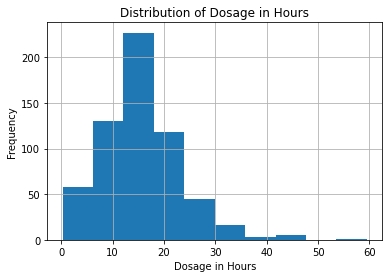

In [22]:
# Let's look at the distribution of dosage in hours
df.groupby(['CY_Student_ID', 'Section_IA']).Monthly_Dosage_Hours.sum().hist()
plt.title('Distribution of Dosage in Hours')
plt.xlabel('Dosage in Hours')
plt.ylabel('Frequency')
plt.show()

Takeaways:
- Most students are around 10-20 hours of tutoring by the end of February

In [18]:
# Turn Month_Year into a datetime object
df.Month_Year = pd.to_datetime(df.Month_Year)

In [19]:
df.Month_Year

0      2015-09-01
1      2015-10-01
2      2015-11-01
3      2015-12-01
4      2016-01-01
          ...    
3173   2015-10-01
3174   2015-11-01
3175   2015-12-01
3176   2016-01-01
3177   2016-02-01
Name: Month_Year, Length: 3178, dtype: datetime64[ns]

<AxesSubplot:xlabel='Month_Year', ylabel='Monthly_Dosage_Hours'>

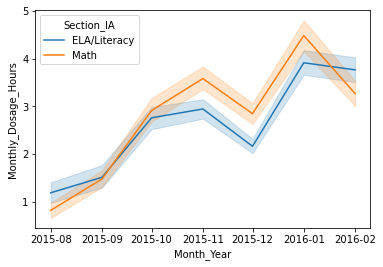

In [21]:
# Let's look at time series chart which shows how dosage trends over the course of the school year
sns.lineplot(x='Month_Year', y='Monthly_Dosage_Hours', data=df, hue='Section_IA')

Takeaways:
- Dosage climbs steadily from August to November but experiences a dip in the month of December
- Dosage for Math tends to increase over time but exp